In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_ind, pearsonr

In [2]:
df = pd.read_csv("/content/historical_data (1).csv")
fg = pd.read_csv("/content/fear_greed_index.csv")

In [3]:
df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [4]:
fg.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [5]:
df.columns=[c.strip() for c in df.columns]
fg.columns=[c.strip() for c in fg.columns]

In [6]:
time_col=None
for c in df.columns:
    if 'time' in c.lower()or'date' in c.lower():
        time_col= c
        break
if time_col is None:
    df['time']=pd.to_datetime(df.iloc[:,0],errors='coerce')
else:
    df['time']=pd.to_datetime(df[time_col],errors='coerce')

In [8]:
pnl_col=None
for c in df.columns:
    if 'pnl' in c.lower() or ('closed' in c.lower() and 'price' not in c.lower()):
        pnl_col=c
        break
if pnl_col is None:
    df['closedPnL']=0
else:
    df = df.rename(columns={pnl_col:'closedPnL'})
    df['closedPnL']=pd.to_numeric(df['closedPnL'], errors='coerce').fillna(0)

In [9]:
size_col=None
for c in df.columns:
    if c.lower() in ['size','qty','quantity','volume']:
        size_col=c
        break
if size_col is None:
    df['size']=1
else:
    df=df.rename(columns={size_col:'size'})
    df['size']=pd.to_numeric(df['size'], errors='coerce').fillna(0)


In [11]:
leverage_col=None
for c in df.columns:
    if 'lev' in c.lower():
        leverage_col = c
        break
if leverage_col is None:
    df['leverage'] = 1
else:
    df=df.rename(columns={leverage_col:'leverage'})
    df['leverage']=pd.to_numeric(df['leverage'], errors='coerce').fillna(1)
side_col=None
for c in df.columns:
    if c.lower() in ['side','direction','trade_side']:
        side_col=c
        break
if side_col is None:
    df['side']='unknown'
else:
    df=df.rename(columns={side_col:'side'})
    df['side']=df['side'].astype(str)

In [12]:
account_col=None
for c in df.columns:
    if 'account' in c.lower() or 'user' in c.lower() or c.lower()=='id':
        account_col=c
        break
if account_col is None:
    df['account']='unknown'
else:
    df = df.rename(columns={account_col:'account'})

In [13]:
df['date']=df['time'].dt.date
df['is_win']=(df['closedPnL']>0).astype(int)

In [14]:
agg=df.groupby('date').agg(total_trades=('account','count'),
                total_volume=('size','sum'),
                    mean_closedPnL=('closedPnL','mean'),
                          median_closedPnL=('closedPnL','median'),win_rate=('is_win','mean'),
                             avg_leverage=('leverage','mean'),long_trades=('side', lambda x: (x.str.lower().str.contains('buy')).sum()),
                             short_trades=('side', lambda x: (x.str.lower().str.contains('sell')).sum()))
agg=agg.reset_index()
agg['long_short_ratio']=agg['long_trades'] / (agg['short_trades'].replace(0,np.nan))
agg['date']=pd.to_datetime(agg['date'])

In [15]:
if 'Date' in fg.columns:
    fg['Date']=pd.to_datetime(fg['Date'], errors='coerce')
else:
    fg.iloc[:,0]=pd.to_datetime(fg.iloc[:,0], errors='coerce')
    fg = fg.rename(columns={fg.columns[0]:'Date'})

/tmp/ipython-input-1360337034.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      1970-01-01 00:00:01.517463000
1      1970-01-01 00:00:01.517549400
2      1970-01-01 00:00:01.517635800
3      1970-01-01 00:00:01.517722200
4      1970-01-01 00:00:01.517808600
                    ...             
2639   1970-01-01 00:00:01.745818200
2640   1970-01-01 00:00:01.745904600
2641   1970-01-01 00:00:01.745991000
2642   1970-01-01 00:00:01.746077400
2643   1970-01-01 00:00:01.746163800
Name: timestamp, Length: 2644, dtype: datetime64[ns]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fg.iloc[:,0] = pd.to_datetime(fg.iloc[:,0], errors='coerce')


In [16]:
fg['date']=fg['Date'].dt.date

In [17]:
cls_col=None
for c in fg.columns:
    if 'class' in c.lower() or 'fear' in c.lower() or 'greed' in c.lower() or 'sentiment' in c.lower():
        cls_col=c
        break
if cls_col is None:
    fg['Classification']=np.nan
else:
    fg = fg.rename(columns={cls_col:'Classification'})

In [18]:
fg['date']=pd.to_datetime(fg['date'])
fg_unique=fg[['date','Classification']].drop_duplicates()

In [21]:
mapping = {'Extreme Fear':0,'Fear':1,'Neutral':2,'Greed':3,'Extreme Greed':4}
fg_unique['sentiment_score'] = fg_unique['Classification'].map(mapping)
agg=agg.merge(fg_unique, on='date', how='left')
agg.to_csv('merged_metrics.csv', index=False)
agg_clean =agg.dropna(subset=['sentiment_score']).copy()
fear_mask= agg_clean['sentiment_score']<=1
greed_mask= agg_clean['sentiment_score']>=3
fear_pnls =agg_clean.loc[fear_mask,'mean_closedPnL']
greed_pnls= agg_clean.loc[greed_mask,'mean_closedPnL']
tt_res=None
corr_res=None
try:
    tt_res=ttest_ind(fear_pnls.dropna(), greed_pnls.dropna(), equal_var=False)
except:
    tt_res=None
try:
    corr_res=pearsonr(agg_clean['sentiment_score'].fillna(0), agg_clean['mean_closedPnL'].fillna(0))
except:
    corr_res=None

/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


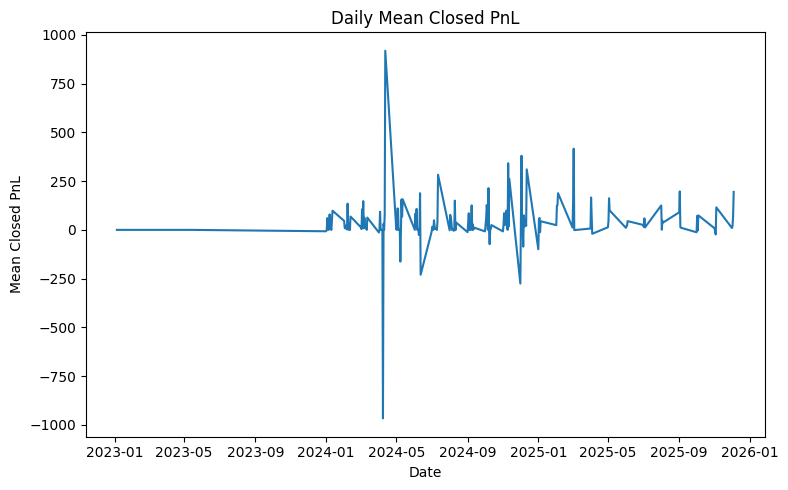

In [22]:
plt.figure(figsize=(8,5))
plt.plot(agg['date'], agg['mean_closedPnL'])
plt.title('Daily Mean Closed PnL')
plt.xlabel('Date')
plt.ylabel('Mean Closed PnL')
plt.tight_layout()
plt.show()

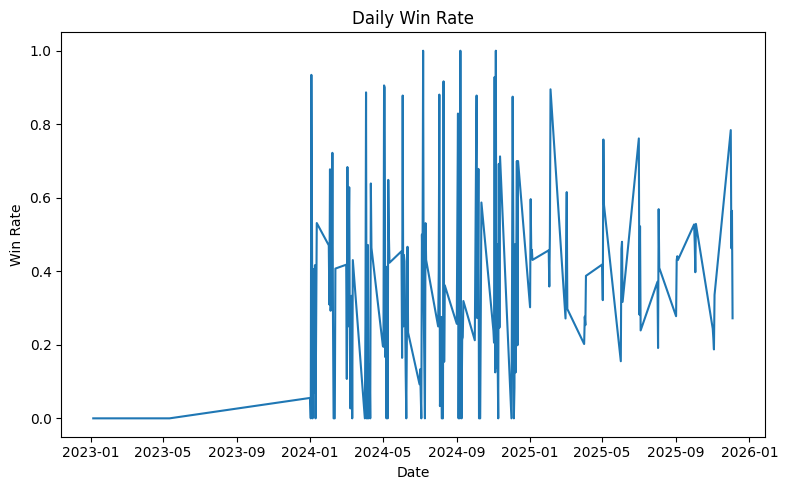

In [23]:
plt.figure(figsize=(8,5))
plt.plot(agg['date'], agg['win_rate'])
plt.title('Daily Win Rate')
plt.xlabel('Date')
plt.ylabel('Win Rate')
plt.tight_layout()
plt.show()

In [24]:
trade_level=df.copy()
trade_level['date']=pd.to_datetime(trade_level['date'])
trade_level = trade_level.merge(fg_unique, on='date', how='left')
if 'sentiment_score' not in trade_level.columns:
    trade_level['sentiment_score']=trade_level['Classification'].map(mapping)
trade_level['sentiment_score']=trade_level['sentiment_score'].fillna(trade_level['sentiment_score'].median())

In [25]:
feature_cols=[]
if 'size' in trade_level.columns:
    feature_cols.append('size')
if 'leverage' in trade_level.columns:
    feature_cols.append('leverage')
if 'sentiment_score' in trade_level.columns:
    feature_cols.append('sentiment_score')
trade_level=trade_level.dropna(subset=feature_cols+['is_win'])
X = trade_level[feature_cols]
y = trade_level['is_win']

In [27]:
if len(y.unique())>=2:
    X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_scaled, y_train)
    probs = lr.predict_proba(X_test_scaled)[:,1]
    auc_lr = roc_auc_score(y_test, probs)
    print("Logistic Reg AUC:", auc_lr)
    print(classification_report(y_test, (probs>=0.5).astype(int)))
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_probs = rf.predict_proba(X_test)[:,1]
    auc_rf = roc_auc_score(y_test, rf_probs)
    print("Random Forest AUC:", auc_rf)
    print(classification_report(y_test, (rf_probs>=0.5).astype(int)))

In [28]:
results_summary = {
    'ttest_statistic':float(tt_res.statistic) if tt_res is not None else None,
    'ttest_pvalue':float(tt_res.pvalue) if tt_res is not None else None,
    'pearson_r':float(corr_res[0]) if corr_res is not None else None,
    'pearson_pvalue':float(corr_res[1]) if corr_res is not None else None,
    'logistic_auc':float(auc_lr) if 'auc_lr' in locals() else None,
    'rf_auc':float(auc_rf) if 'auc_rf' in locals() else None
}
pd.DataFrame([results_summary]).to_csv('model_metrics.csv',index=False)